In [3]:
import numpy as np
import pandas as pd

## location of the csv file
url = "https://hilpisch.com/nov25eod.csv"

## read the csv file, and set the first column as date
panel = pd.read_csv(
    url,
    index_col=0,
    parse_dates = True,
)

## sort based on the dates
panel = panel.sort_index()

## get missing number based on each column
missing_by_col = panel.isna().sum()

print(missing_by_col)

AAPL         0
NVDA         0
JPM          0
SPY          0
GLD          0
TLT          0
EURUSD     312
BTC-USD      0
dtype: int64


In [4]:
## choose AAPL
appl_prices = panel["AAPL"].astype(float)

##simple return
simple_ret = appl_prices.pct_change()
##log return
log_ret = np.log(appl_prices / appl_prices.shift(1))

daily = log_ret.dropna()

##get statistics data using function
def stats(x):
    return pd.Series({
        "count": x.count(),
        "mean": x.mean(),
        "std": x.std(ddof=1),
        "min":x.min(),
        "max": x.max(),
        "skew": x.skew(),
        "kurtosis":x.kurt(),
    })

summary = pd.DataFrame({"simple": stats(simple_ret), "log": stats(log_ret)})
summary

,simple,log
count,2514.000000,2514.000000
mean,0.001102,0.000934
std,0.018345,0.018326
min,-0.128647,-0.137708
max,0.153288,0.142617
skew,0.150295,-0.088038
kurtosis,6.852301,6.623756


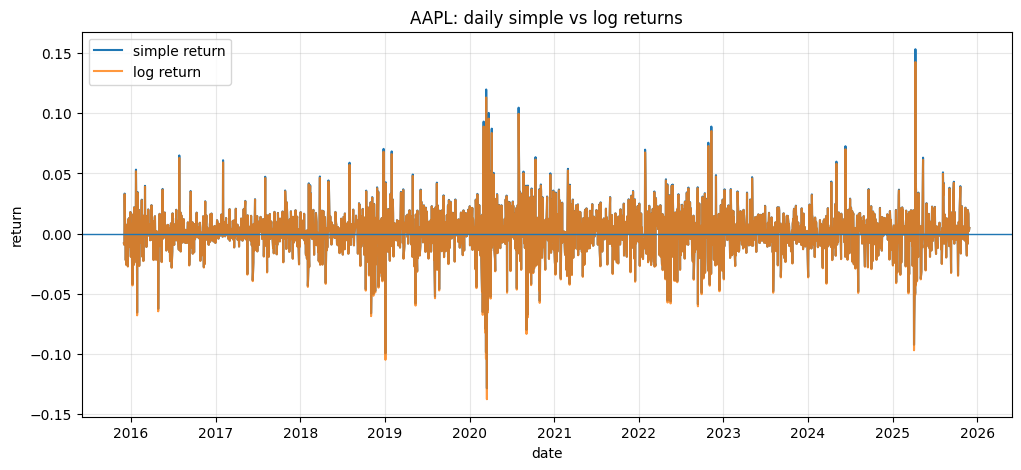

In [7]:
import matplotlib.pyplot as plt

df = pd.DataFrame({"simple":simple_ret, "log":log_ret}).dropna()

## use plot to show log return and simple return
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["simple"], label="simple return")
plt.plot(df.index, df["log"], label="log return", alpha=0.8)
plt.axhline(0, linewidth=1)
plt.title("AAPL: daily simple vs log returns")
plt.ylabel("return")
plt.xlabel("date")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [ ]:
## two line almost overlap most of time. EOD move are small.
## diffference can be seen when there is spikes.

In [8]:
# get the raw panel
raw = panel.copy()

## keep only the rows with no missing across all asset
panel_final = raw.dropna(axis=0, how="any")

## calculate the data set different
dropped = raw.shape[0] - panel_final.shape[0]

#percentage left
kept_pct = panel_final.shape[0] / raw.shape[0] *100

dropped, kept_pct

## this can guarantee the full analysis across all instruments. avoid issues in train and backtests.
## if the data dropped is too much, it can cause the unreliable analysis.

(312, 87.5944333996024)

In [9]:
window_short =20
window_long = 60

prices = panel["AAPL"].astype(float)

#daily log return
ret = np.log(prices / prices.shift(1))

## features:
mom20 = ret.rolling(window_short).sum()
vol60 = ret.rolling(window_long).std(ddof=1)
rev5 = -ret.rolling(5).sum()

## when the target is next day return:
target_next= ret.shift(-1)

df = pd.DataFrame({
    "mom20": mom20,
    "vol60": vol60,
    "rev5": rev5,
    "target_next": target_next
}).dropna()

df.head(10)

,mom20,vol60,rev5,target_next
Date,,,,
2016-02-26,0.034943,0.019798,-0.009021,-0.002274
2016-02-29,-0.001286,0.019788,0.001964,0.038946
2016-03-01,0.047050,0.020502,-0.059849,0.002187
2016-03-02,0.069668,0.020489,-0.047256,0.007416
2016-03-03,0.057485,0.020015,-0.047824,0.014767
2016-03-04,0.064247,0.020133,-0.061042,-0.011127
2016-03-07,0.080193,0.020164,-0.052189,-0.008283
2016-03-08,0.061436,0.020010,-0.004959,0.000890
2016-03-09,0.062535,0.019993,-0.003662,0.000497


In [10]:
## get the top 5
top5 = ret.abs().nlargest(5)
top5

## three of them are close to 2020-03. there might be an event happends around that time.

Date
2025-04-09    0.142617
2020-03-16    0.137708
2020-03-13    0.113158
2019-01-03    0.104923
2020-03-12    0.103978
Name: AAPL, dtype: float64

In [3]:
# wrappers/tpqeod.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Optional, Literal, Dict, Any
import io

import pandas as pd
import requests


Agg = Optional[Literal["D", "W", "M"]]  # daily/weekly/monthly
IntradayInterval = Literal["1m", "5m", "1h"]


@dataclass
class EODHDClient:
    """
    Thin wrapper around the EODHD HTTP API that returns pandas objects.
    """
    api_token: str
    base_url: str = "https://eodhd.com/api"

    @classmethod
    def from_creds(
        cls,
        creds_module: str = "creds",
        token_var: str = "eod_key",
        base_url: str = "https://eodhd.com/api",
    ) -> "EODHDClient":
        mod = __import__(creds_module)
        if not hasattr(mod, token_var):
            raise AttributeError(f"'{creds_module}.py' must define '{token_var}'.")
        token = getattr(mod, token_var)
        if not isinstance(token, str) or not token.strip():
            raise ValueError(f"{creds_module}.{token_var} must be a non-empty string.")
        return cls(api_token=token.strip(), base_url=base_url)

    # ---------- internal helpers ----------

    def _get_csv(self, path: str, params: Dict[str, Any], verify: bool = True) -> pd.DataFrame:
        url = f"{self.base_url.rstrip('/')}/{path.lstrip('/')}"
        q = dict(params)
        q["api_token"] = self.api_token
        q.setdefault("fmt", "csv")

        r = requests.get(url, params=q, timeout=30, verify=verify)
        r.raise_for_status()

        text = r.text.strip()
        if text.lower().startswith("error") or "invalid" in text.lower():
            raise RuntimeError(f"EODHD API error response: {text[:200]}")

        return pd.read_csv(io.StringIO(text))

    @staticmethod
    def _set_datetime_index(df: pd.DataFrame, date_col: str) -> pd.DataFrame:
        if date_col not in df.columns:
            raise ValueError(f"Expected column '{date_col}' in response, got {list(df.columns)}")

        out = df.copy()
        out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
        out = out.dropna(subset=[date_col]).set_index(date_col).sort_index()
        out.index.name = "Date"
        return out

    # ---------- public API ----------

    def get_eod(
        self,
        symbol: str,
        exchange: Optional[str] = "US",
        start: Optional[str] = None,
        end: Optional[str] = None,
        adjusted: bool = True,
        verify_ssl: bool = True,
    ) -> pd.DataFrame:
        """
        Fetch end-of-day OHLCV history for one symbol.
        Returns a DataFrame indexed by Date.
        """
        ticker = f"{symbol}.{exchange}" if exchange else symbol

        params: Dict[str, Any] = {"adjusted": "1" if adjusted else "0"}
        if start:
            params["from"] = start
        if end:
            params["to"] = end

        df = self._get_csv(path=f"eod/{ticker}", params=params, verify=verify_ssl)

        # EODHD sometimes uses 'date' column (lowercase) in CSV.
        # If your response uses 'Date', this handles it too.
        if "date" in df.columns:
            df = self._set_datetime_index(df, "date")
        elif "Date" in df.columns:
            df = self._set_datetime_index(df, "Date")
        else:
            raise ValueError(f"No date column found. Columns: {list(df.columns)}")

        # numeric conversion
        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="ignore")

        return df

    def get_intraday(
        self,
        symbol: str,
        exchange: Optional[str] = "US",
        period: IntradayInterval = "5m",
        start: Optional[str] = None,
        end: Optional[str] = None,
        verify_ssl: bool = True,
    ) -> pd.DataFrame:
        """
        Fetch intraday OHLCV bars for one symbol.
        Returns a DataFrame indexed by Date (timestamp).
        """
        ticker = f"{symbol}.{exchange}" if exchange else symbol

        params: Dict[str, Any] = {"interval": period}
        if start:
            params["from"] = start
        if end:
            params["to"] = end

        df = self._get_csv(path=f"intraday/{ticker}", params=params, verify=verify_ssl)

        # Intraday usually uses 'datetime' or sometimes 'Date'
        if "datetime" in df.columns:
            df = self._set_datetime_index(df, "datetime")
        elif "Date" in df.columns:
            df = self._set_datetime_index(df, "Date")
        elif "date" in df.columns:
            df = self._set_datetime_index(df, "date")
        else:
            raise ValueError(f"No datetime/date column found. Columns: {list(df.columns)}")

        for c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="ignore")

        return df

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 50)

In [ ]:
## timestamps: date, like YYYY-MM-DD HH:MM:SS
## Symbol : AAPL, SPY.  can also be ISIN
## Exchange: US
## Price:  Open, close, high, low
## Volume: traded volume

## the raw version should not be cover.
## raw
## then can be another file :adjusted-raw
## then do the analysis on the adjusted file


C:\Users\m502251\CPF\Assignment\wrappers\tpqeod.py:103: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
C:\Users\m502251\CPF\Assignment\wrappers\tpqeod.py:103: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


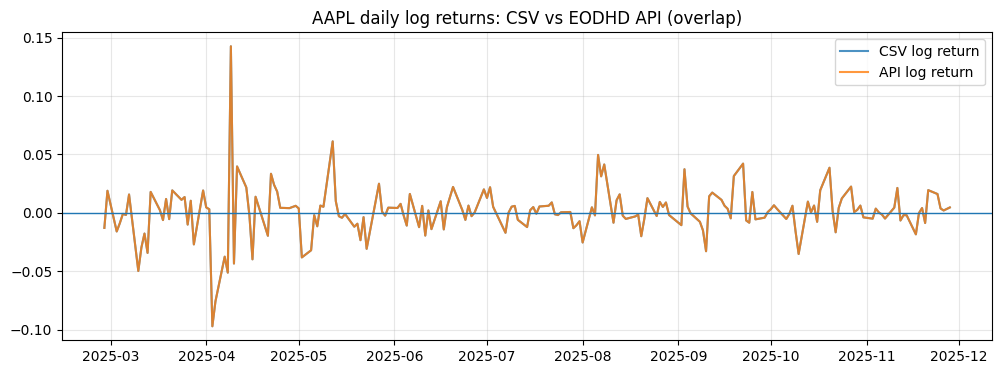

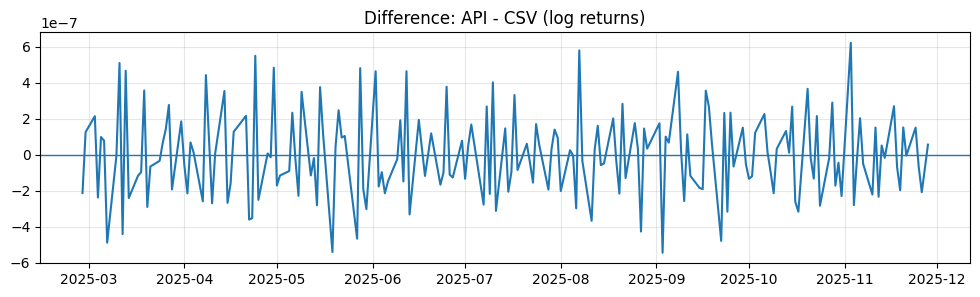

In [7]:
import numpy as np
import pandas as pd

from wrappers.tpqeod import EODHDClient

client = EODHDClient.from_creds()

aapl_eod = client.get_eod("AAPL", "US")

## extract the price from earlier homework, csv

## location of the csv file
url = "https://hilpisch.com/nov25eod.csv"

## read the csv file, and set the first column as date
panel = pd.read_csv(
    url,
    index_col=0,
    parse_dates = True,
)

## sort based on the dates
panel = panel.sort_index()

## get missing number based on each column
missing_by_col = panel.isna().sum()


aapl_prices_csv = panel["AAPL"].astype(float)
aapl_ret_csv = np.log(aapl_prices_csv / aapl_prices_csv.shift(1)).dropna()

## get the time of csv file:
start = aapl_prices_csv.index.min().strftime("%Y-%m-%d")
end   = aapl_prices_csv.index.max().strftime("%Y-%m-%d")

## get price from API
aapl_eod = client.get_eod("AAPL", "US", start=start, end=end, adjusted=True)
aapl_eod.columns = aapl_eod.columns.str.strip().str.lower()
close_col = "adjusted_close" if "adjusted_close" in aapl_eod.columns else "close"
aapl_prices_api = aapl_eod[close_col].astype(float).sort_index()
# aapl_prices_api = aapl_eod["close"].astype(float).sort_index()

## get return
aapl_ret_api = np.log(aapl_prices_api / aapl_prices_api.shift(1)).dropna()

comp = pd.concat(
    {"csv": aapl_ret_csv, "api": aapl_ret_api},
    axis=1
).dropna()

comp["diff"] = comp["api"] - comp["csv"]

import matplotlib.pyplot as plt

# plot of overlay returns
plt.figure(figsize=(12,4))
plt.plot(comp.index, comp["csv"], label="CSV log return", alpha=0.8)
plt.plot(comp.index, comp["api"], label="API log return", alpha=0.8)
plt.axhline(0, linewidth=1)
plt.title("AAPL daily log returns: CSV vs EODHD API (overlap)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## plot of difference
plt.figure(figsize=(12,3))
plt.plot(comp.index, comp["diff"])
plt.axhline(0, linewidth=1)
plt.title("Difference: API - CSV (log returns)")
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
## Pitfall when working with API

## Network. DNS failure, connection refused, timeouts.
## Server unavailable
## Inconsistent column names ( not fatal)
## Schema changes ( not fatal)
## Credential securities 

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) intraday 
intraday = client.get_intraday("AAPL", "US", period="5m")
intraday = intraday.sort_index()
intraday.columns = intraday.columns.str.strip().str.lower()

intraday_daily = pd.DataFrame({
    "open": intraday["open"].resample("D").first(),
    "high": intraday["high"].resample("D").max(),
    "low": intraday["low"].resample("D").min(),
    "close": intraday["close"].resample("D").last(),
    "volume": intraday["volume"].resample("D").sum(),
}).dropna()

# 2) intraday -> daily close (last bar close)
intraday_close_daily = intraday["close"].astype(float).resample("D").last().dropna()
intraday_close_daily.index = intraday_close_daily.index.normalize()

# 3) pull EOD only for the dates we actually have intraday
start = intraday_close_daily.index.min().strftime("%Y-%m-%d")
end   = intraday_close_daily.index.max().strftime("%Y-%m-%d")

eod = client.get_eod("AAPL", "US", start=start, end=end, adjusted=False)
eod = eod.sort_index()
eod.columns = eod.columns.str.strip().str.lower()
eod.index = pd.to_datetime(eod.index).normalize()

eod_close = eod["close"].astype(float)

# 4) align + diff
cmp = pd.concat(
    [intraday_close_daily.rename("close_intraday"),
     eod_close.rename("close_eod")],
    axis=1
).dropna()

cmp["diff"] = cmp["close_intraday"] - cmp["close_eod"]

print(cmp.head())
print(cmp["diff"].describe())

# 5) plot diff
plt.figure(figsize=(12,4))
plt.plot(cmp.index, cmp["diff"])
plt.axhline(0, linewidth=1)
plt.title("AAPL close difference (intraday aggregated close − EOD close)")
plt.ylabel("difference")
plt.grid(True, alpha=0.3)
plt.show()

HTTPError: 403 Client Error: Forbidden for url: https://eodhd.com/api/intraday/AAPL.US?interval=5m&api_token=69a00ccc273c65.16530568&fmt=csv